In [1]:
from pathlib import Path
import torch
from torch.utils.data import ConcatDataset

from deepmash.data_processing.common import get_dataloaders, ToLogMel, load_stem_audio
from deepmash.data_processing.gtzan_stems import GTZANStemsDataset
from deepmash.data_processing.musdb18 import MUSDB18Dataset
from deepmash.data_processing.constants import *

# reload imported modules automatically (so you dont have to restart kernel when changing .py files)
%load_ext autoreload
%autoreload 2

/Users/valle/Library/CloudStorage/OneDrive-KTH/Dokument/KTH/musik-dt2470/deep-mash/.venv/lib/python3.13/site-packages/stempeg/__init__.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [13]:
ds_musdb_train = MUSDB18Dataset(
    root_dir="datasets/musdb18",
    split="train",
    already_preprocessed=True,
    # preprocess_transform=ToLogMel(),
)
ds_musdb_test = MUSDB18Dataset(
    root_dir="datasets/musdb18",
    split="test",
    already_preprocessed=False,
    # preprocess_transform=ToLogMel(),
)

ds_gtzan = GTZANStemsDataset(
    root_dir="datasets/gtzan-stems",
    already_preprocessed=False,
    preprocess_transform=ToLogMel(),
)

Preprocessing stems from datasets/musdb18/test to datasets/musdb18-processed/test ...


  0%|          | 0/50 [00:00<?, ?it/s]

Preprocessing stems from datasets/gtzan-stems to datasets/gtzan-stems-processed ...


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/valle/Library/CloudStorage/OneDrive-KTH/Dokument/KTH/musik-dt2470/deep-mash/.venv/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [8]:
ds_musdb = ConcatDataset([ds_musdb_train, ds_musdb_test])
len(ds_gtzan), len(ds_musdb)

(2000, 2084)

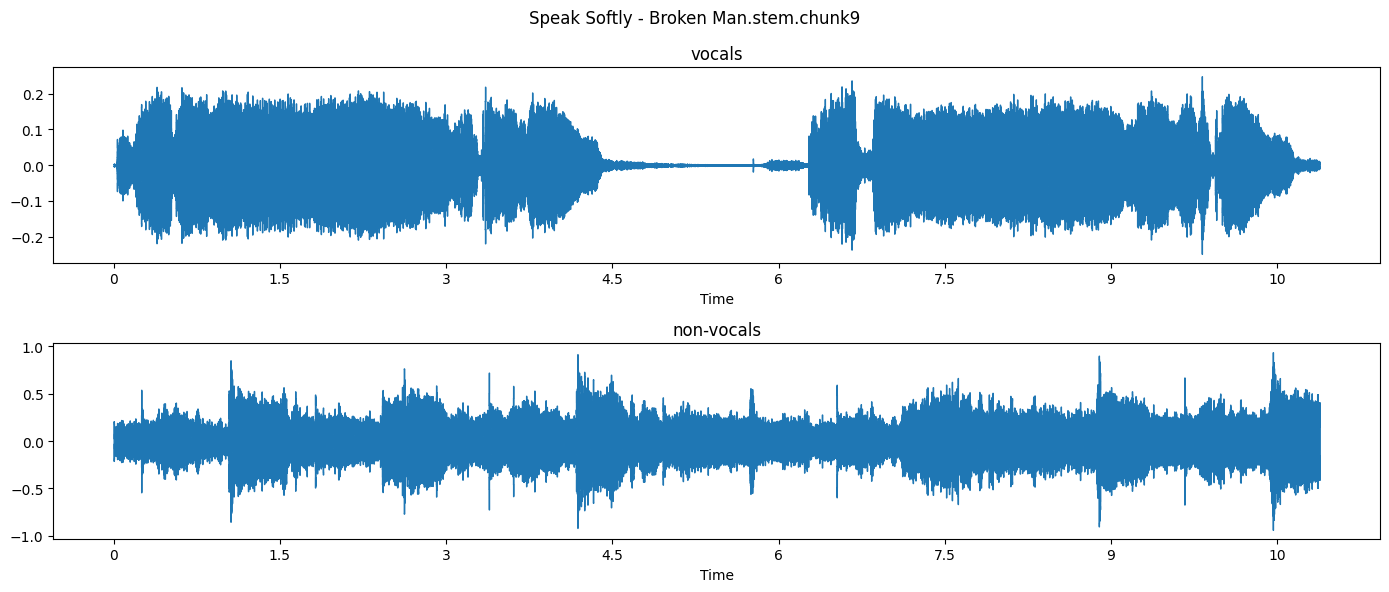

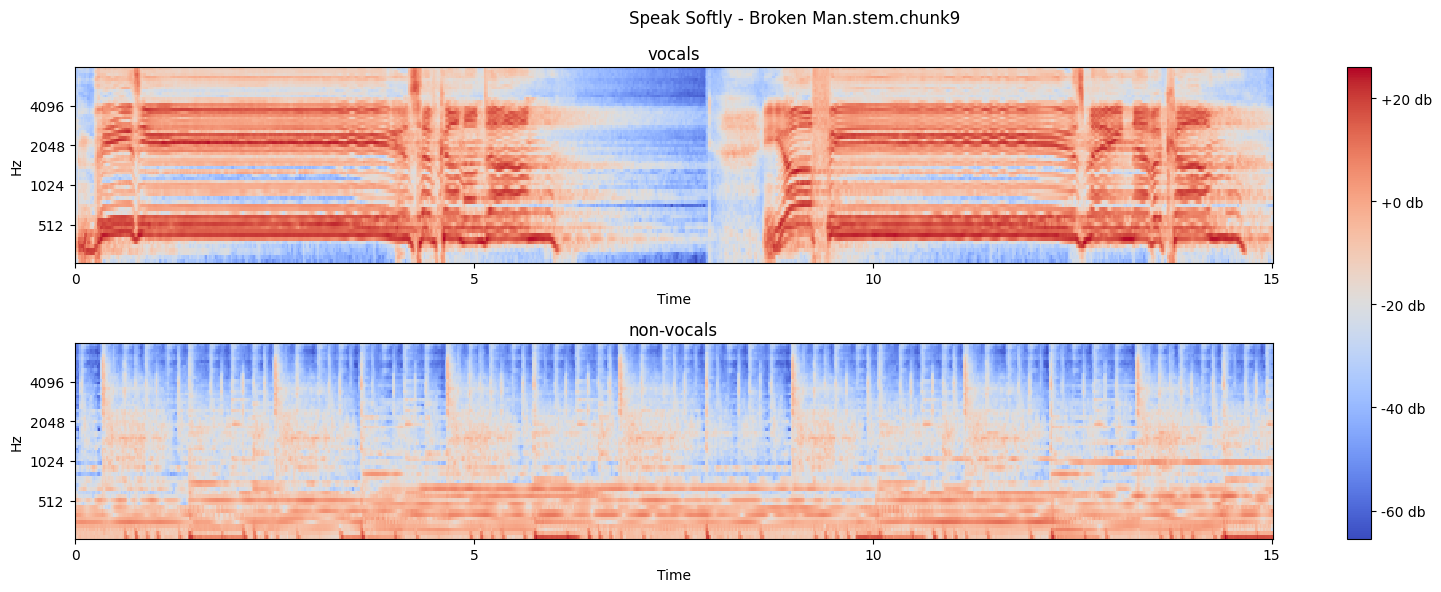

vocals: shape=torch.Size([64, 751]), mean=-9.479867935180664
non-vocals: shape=torch.Size([64, 751]), mean=5.362552165985107


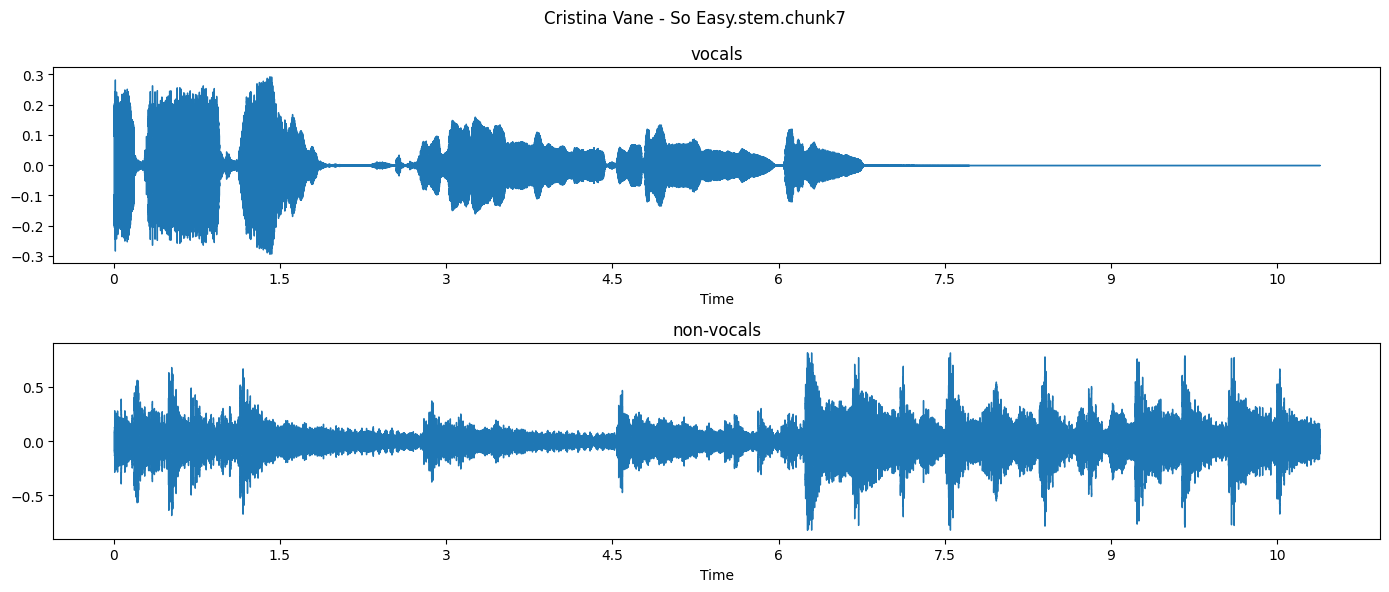

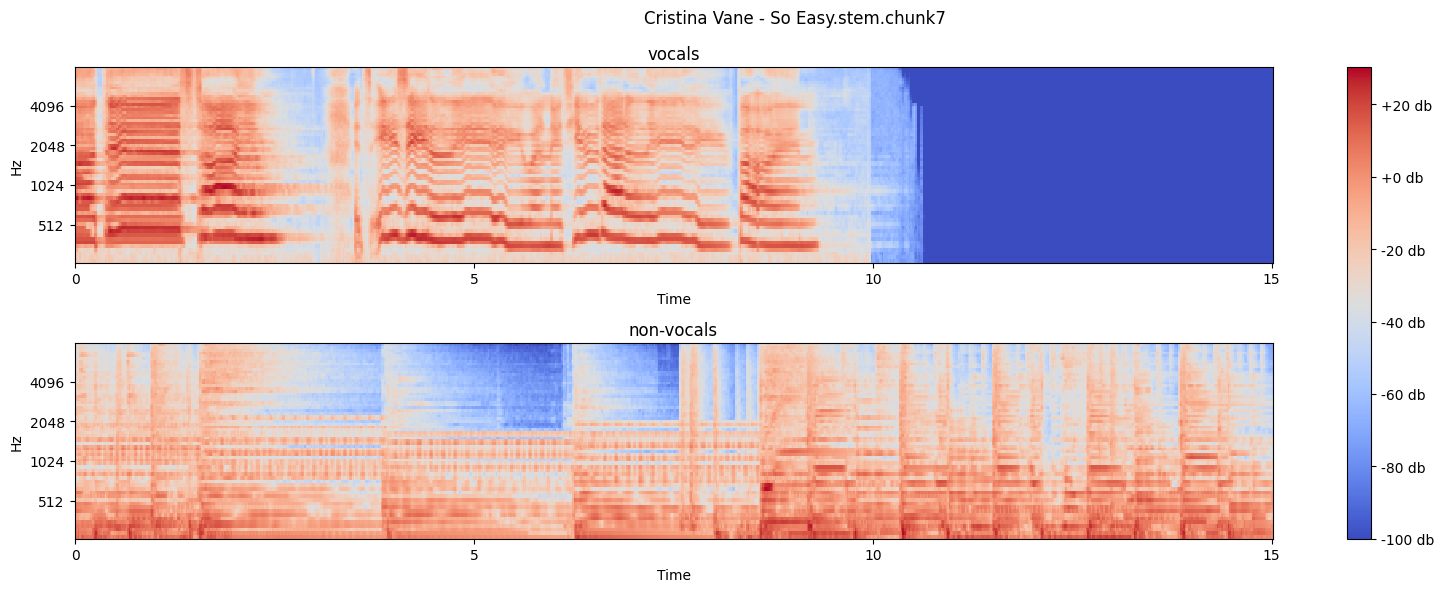

vocals: shape=torch.Size([64, 751]), mean=-44.19491195678711
non-vocals: shape=torch.Size([64, 751]), mean=-0.5563991069793701


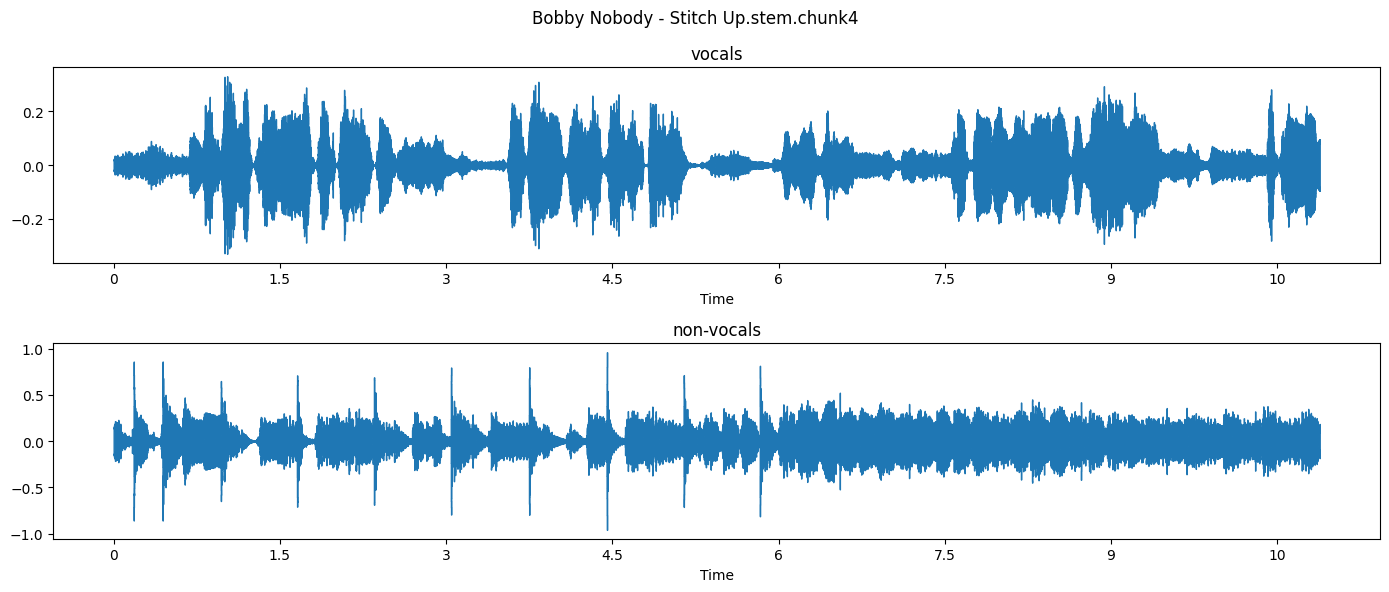

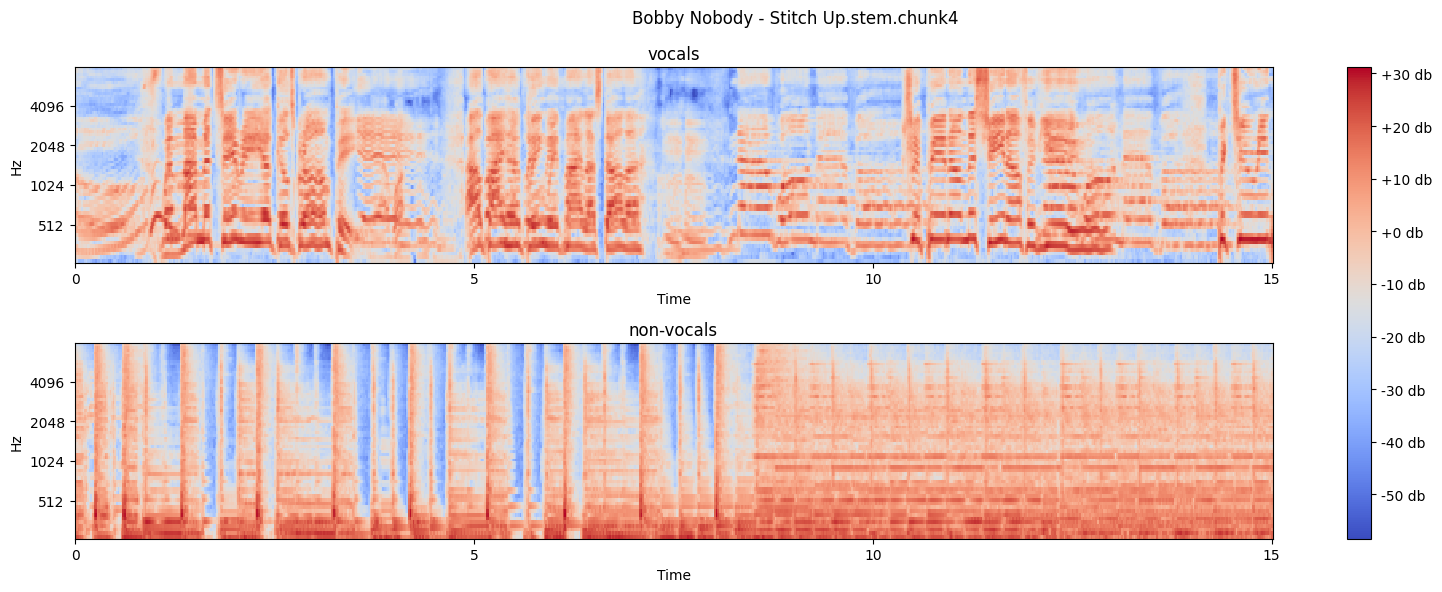

vocals: shape=torch.Size([64, 751]), mean=-9.375115394592285
non-vocals: shape=torch.Size([64, 751]), mean=0.27944040298461914


In [16]:
import random
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

from deepmash.data_processing.common import StemsDataset

def display_melspec(vocals: torch.Tensor, non_vocals: torch.Tensor, track_name: str):
    fig, axs = plt.subplots(2,1, figsize=(16, 6))
    fig.suptitle(track_name)
    axs[0].set_title("vocals"); axs[1].set_title("non-vocals")
    im0 = librosa.display.specshow(vocals.numpy(), sr=TARGET_SR, hop_length=HOP_SIZE, n_fft=WINDOW_SIZE, fmin=F_MIN, fmax=F_MAX,
                             x_axis="time", y_axis="mel", ax=axs[0])
    im1 = librosa.display.specshow(non_vocals.numpy(), sr=TARGET_SR, hop_length=HOP_SIZE, n_fft=WINDOW_SIZE, fmin=F_MIN, fmax=F_MAX,
                             x_axis="time", y_axis="mel", ax=axs[1])
    fig.tight_layout()
    fig.colorbar(im0, ax=axs, format="%+.0f db")
    plt.show()

def display_processed_chunk(p: Path):
    track_name = p.name
    vocals = torch.load(p/"vocals.pt").squeeze()
    non_vocals = torch.load(p/"non_vocals.pt").squeeze()

    if vocals.ndim == 1 and non_vocals.ndim == 1:
        vocals_np, non_vocals_np = vocals.numpy(), non_vocals.numpy()
        fig, axs = plt.subplots(2,1, figsize=(14,6))
        fig.suptitle(track_name)
        axs[0].set_title("vocals"); axs[1].set_title("non-vocals")
        librosa.display.waveshow(vocals_np, ax=axs[0])
        librosa.display.waveshow(non_vocals_np, ax=axs[1])
        fig.tight_layout()

        display(Audio(vocals_np, rate=TARGET_SR))
        display(Audio(non_vocals_np, rate=TARGET_SR))
        
        vocals_mel = ToLogMel()(vocals)
        non_vocals_mel = ToLogMel()(non_vocals)
        display_melspec(vocals_mel, non_vocals_mel, track_name)
        
        print(f"vocals: shape={vocals_mel.shape}, mean={vocals_mel.mean()}")
        print(f"non-vocals: shape={non_vocals_mel.shape}, mean={non_vocals_mel.mean()}")
    
    elif vocals.ndim == 2 and non_vocals.ndim == 2:
        display_melspec(vocals, non_vocals, track_name)
    
    else:
        print(f"Unexpected tensor shapes: vocals {vocals.shape}, non-vocals {non_vocals.shape}")

def display_random_chunk(dataset: StemsDataset):
    all_paths = list(p.parent for p in dataset.processed_root.glob(r"*/*.pt"))
    p = random.choice(all_paths)
    display_processed_chunk(p)

for _ in range(3):
    display_random_chunk(ds_musdb_test)